In [2]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import random
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
import scipy.stats as stats
from scipy.stats import binom
import scipy
import itertools
from collections import Counter
from collections import defaultdict
import functools
%matplotlib inline

In [6]:
#low expression populations
s1path ="C:\\Users\\Wolf\\Desktop\\SynPro\\Complete data\\S1.fa.uniq.tcga.reform.all.csv"
s3path ="C:\\Users\\Wolf\\Desktop\\SynPro\\Complete data\\S3.fa.uniq.tcga.reform.all.csv"
s5path ="C:\\Users\\Wolf\\Desktop\\SynPro\\Complete data\\S5.fa.uniq.tcga.reform.all.csv"
#high expression populations
s2path ="C:\\Users\\Wolf\\Desktop\\SynPro\\Complete data\\S2.fa.uniq.tcga.reform.all.csv"
s4path ="C:\\Users\\Wolf\\Desktop\\SynPro\\Complete data\\S4.fa.uniq.tcga.reform.all.csv"
s6path ="C:\\Users\\Wolf\\Desktop\\SynPro\\Complete data\\S6.fa.uniq.tcga.reform.all.csv"
s7path ="C:\\Users\\Wolf\\Desktop\\SynPro\\Complete data\\S7.fa.uniq.tcga.reform.all.csv"

In [3]:
#low expression populations
s1path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S1.fa.uniq.tcga.reform.all.csv"
s3path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S3.fa.uniq.tcga.reform.all.csv"
s5path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S5.fa.uniq.tcga.reform.all.csv"
#high expression populations
s2path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S2.fa.uniq.tcga.reform.all.csv"
s4path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S4.fa.uniq.tcga.reform.all.csv"
s6path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S6.fa.uniq.tcga.reform.all.csv"
#restimulated population
s7path ="Z:/PROJECTS/Synthetic Promoters/Library#1/Miseq data/Complete Data/S7.fa.uniq.tcga.reform.all.csv"

In [21]:
###this set of code seeks to build a partly binary model for TRE association, incorporating sequence length in predicting association###
#read in a csv with a single column, split to divide '# of hits' from 'TRE code description', filter out TREs with < 2 hits
def read_in(filepath):
    dfs1 = pd.read_csv(filepath, engine='python', sep=None, header=None)
    dfs1.columns = ['count','rawcode']
    dfs1 = dfs1.loc[dfs1['count'] > 2]
    return dfs1

#retrieve just the numeric code for the TRE (ignoring forward or reverse orientation)
def extract_code(df):
    toparse = df['rawcode'].tolist()
    code = []
    for s in toparse:
        singlecode = [c for c in s if not c.isupper()]
        jcode = ''.join(singlecode)
        code.append(jcode)
    df['code'] = code
    df['code'] = df['code'].str.replace('r', ' ')
    df['code'] = df['code'].str.replace('f', ' ')
    return df

def full_binary_length_testing(path):
    df = extract_code(read_in(path))
    dfs = df[['count','code']]
    
    #split the TRE string into a list of integers
    comma_list = []
    for l in dfs['code'].values:
        results = list(map(int, l.split()))
        comma_list.append(results)
    
    dfs['code'] = comma_list
    weighted_list = list((zip(dfs['code'].values, dfs['count'].values, [len(l) for l in comma_list])))
    
    #retrieve global probability of drawing singlet
    query_list = list(range(1, 12))
    singlets = dict(Counter(list(itertools.chain.from_iterable([tup[0] for tup in weighted_list]))))
    singlet_sum = sum(singlets.values(), 0.0)
    singlet_probs = {k: v/singlet_sum for k, v in singlets.items()}
    
    #retrieve boolean dublet outcomes
    possible_dublets = list((itertools.combinations(query_list, 2)))
    boolean_dublet_query =[]
    for val in possible_dublets:
        single_dub_query =[]
        for l in weighted_list:
            if all(x in l[0] for x in val):
                single_dub_query.append(1)
            else:
                single_dub_query.append(0)
        boolean_dublet_query.append(single_dub_query)
    
    #create df to store binary outcomes of dublets, weights, lengths, and singlet probabilities for len(seq)
    dublet_df = pd.DataFrame(boolean_dublet_query).T
    dublet_df.columns = possible_dublets
    dublet_df['weight'] = dfs['count'].values
    dublet_df['length'] = [len(l) for l in comma_list]
    for k, v in singlet_probs.items():
        dublet_df[k] = (1-((1-v)**dublet_df['length']))
        
    #query tuple headers with headers of their elements, subtract multiplied singlet probabilities from dublet binaries
    tuple_columns = [col for col in dublet_df.columns if isinstance(col, tuple)]
    #probs_success_samples = pd.concat([dublet_df['weight'] * dublet_df[col[0]] * dublet_df[col[1]] for col in tuple_columns], axis=1)
    probs_success_samples = pd.concat([dublet_df[col[0]] * dublet_df[col[1]] for col in tuple_columns], axis=1)
    probs_success_samples.columns = tuple_columns
    
    var_probs_samples = pd.concat([dublet_df['weight'] * (dublet_df[col[0]] * dublet_df[col[1]]) * (1 - (dublet_df[col[0]] * dublet_df[col[1]])) for col in tuple_columns], axis=1)
    var_probs_samples.columns = tuple_columns
    
    observed_success_samples = pd.concat([dublet_df['weight'] * dublet_df[col] for col in tuple_columns], axis=1)
    observed_success_samples.columns = tuple_columns
    
    #currently unused, might use for future tests
    def calc_KL(obs, expt):
        obs_mean = obs.sum()
        obs_var = obs.var()
        expt_mean = expt.sum()
        expt_var = expt.var()
        obs_dist = np.random.normal(loc= obs_mean, scale= obs_var, size=100)
        expt_dist = np.random.normal(loc= expt_mean, scale= expt_var, size=100)
        return scipy.stats.entropy(expt_dist, qk = obs_dist)
    
    #For testing whether we can apply a normal distribution statistical approximation
    #coef_var = pd.DataFrame(1/np.var(probs_success_samples))
    
    #given two datasets (expected vs observed), calculate normal CDF of expected and return p-value for observed
    def norm_hypothesis_test(mean_probability_df, var_probability_df, success_df):
        u = mean_probability_df.sum()
        o = var_probability_df.sum()
        return scipy.stats.norm(u, o).cdf(success_df.sum())
    
    #Calculate and sort p-values for a tuple of TREs
    p_values = pd.DataFrame(1 - norm_hypothesis_test(probs_success_samples, var_probs_samples, observed_success_samples))
    p_values.columns = ['p_value']
    p_values['tuples'] = observed_success_samples.columns
    p_values.sort_values('p_value', ascending=True, inplace=True)

    
    #Replace numerical codes with actual TRE names
    trenamedict = {1:'E2F1', 2:'EGR1', 3:'FOS', 4:'HIF1A', 5:'JUN', 6:'NFAT', 7:'LEF1', 8:'NFkB', 9:'SP1', 10:'PU1', 11:'STAT4'}
    def replace_matched_items(word_list, dictionary):
        new_list = [','.join([dictionary.get(item, item) for item in lst]) for lst in word_list]
        return new_list
    p_values['tuples'] = replace_matched_items(p_values.tuples, trenamedict)
    
    #return probs_success_samples, dublet_df['length']
    return 
t_df, seq_len = full_binary_length_testing(s7path)
t_df

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,"(1, 2)","(1, 3)","(1, 4)","(1, 5)","(1, 6)","(1, 7)","(1, 8)","(1, 9)","(1, 10)","(1, 11)",...,"(7, 8)","(7, 9)","(7, 10)","(7, 11)","(8, 9)","(8, 10)","(8, 11)","(9, 10)","(9, 11)","(10, 11)"
0,0.331032,0.393373,0.206421,0.345987,0.398001,0.361597,0.528234,0.318892,0.263105,0.363995,...,0.637403,0.384796,0.317480,0.439220,0.562125,0.463787,0.641629,0.279985,0.387348,0.319585
1,0.154801,0.193545,0.089336,0.163617,0.196662,0.173115,0.317841,0.147829,0.117603,0.174603,...,0.401345,0.186667,0.148499,0.220474,0.342723,0.272647,0.404794,0.126809,0.188271,0.149776
2,0.331032,0.393373,0.206421,0.345987,0.398001,0.361597,0.528234,0.318892,0.263105,0.363995,...,0.637403,0.384796,0.317480,0.439220,0.562125,0.463787,0.641629,0.279985,0.387348,0.319585
3,0.260399,0.315416,0.157592,0.273324,0.319635,0.286986,0.453868,0.250017,0.203407,0.289101,...,0.557214,0.306945,0.249722,0.354930,0.485434,0.394936,0.561321,0.217553,0.309207,0.251563
4,0.365486,0.430428,0.231217,0.381227,0.435171,0.397554,0.561075,0.352640,0.292916,0.400052,...,0.671495,0.422040,0.350562,0.478783,0.595632,0.494754,0.675715,0.310957,0.424692,0.352765
5,0.365486,0.430428,0.231217,0.381227,0.435171,0.397554,0.561075,0.352640,0.292916,0.400052,...,0.671495,0.422040,0.350562,0.478783,0.595632,0.494754,0.675715,0.310957,0.424692,0.352765
6,0.463224,0.532192,0.305382,0.480464,0.536989,0.498008,0.645036,0.448933,0.380105,0.500661,...,0.754456,0.525087,0.444584,0.585589,0.680110,0.575839,0.758474,0.400773,0.527884,0.446952
7,0.295922,0.354963,0.181821,0.309938,0.359417,0.324661,0.492576,0.284604,0.233196,0.326931,...,0.599447,0.346352,0.283791,0.397863,0.525485,0.430568,0.603638,0.248776,0.348774,0.285775
8,0.260399,0.315416,0.157592,0.273324,0.319635,0.286986,0.453868,0.250017,0.203407,0.289101,...,0.557214,0.306945,0.249722,0.354930,0.485434,0.394936,0.561321,0.217553,0.309207,0.251563
9,0.331032,0.393373,0.206421,0.345987,0.398001,0.361597,0.528234,0.318892,0.263105,0.363995,...,0.637403,0.384796,0.317480,0.439220,0.562125,0.463787,0.641629,0.279985,0.387348,0.319585


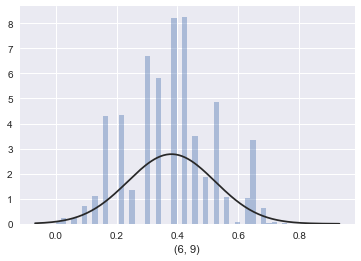

In [22]:
#plot probability of a certain bigram occuring for each sequence
sns.distplot(t_df.ix[:,42], kde=False, fit=scipy.stats.norm)
plt.show()

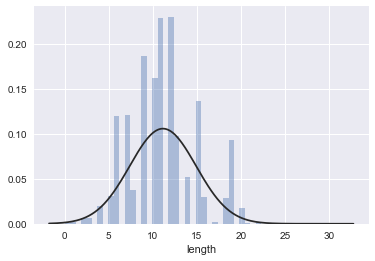

In [23]:
#plot length of sequences (len=#ofTREs)
sns.distplot(seq_len, kde=False, fit=scipy.stats.norm)
plt.show()

In [10]:
###this set of code seeks to build a partly binary model for TRE association, incorporating sequence length in predicting association###
#read in a csv with a single column, split to divide '# of hits' from 'TRE code description', filter out TREs with < 2 hits
def read_in(filepath):
    dfs1 = pd.read_csv(filepath, engine='python', sep=None, header=None)
    dfs1.columns = ['count','rawcode']
    dfs1 = dfs1.loc[dfs1['count'] > 2]
    return dfs1

#retrieve just the numeric code for the TRE (ignoring forward or reverse orientation)
def extract_code(df):
    toparse = df['rawcode'].tolist()
    code = []
    for s in toparse:
        singlecode = [c for c in s if not c.isupper()]
        jcode = ''.join(singlecode)
        code.append(jcode)
    df['code'] = code
    df['code'] = df['code'].str.replace('r', ' ')
    df['code'] = df['code'].str.replace('f', ' ')
    return df

def full_binary_length_testing(path):
    df = extract_code(read_in(path))
    dfs = df[['count','code']]
    
    #split the TRE string into a list of integers
    comma_list = []
    for l in dfs['code'].values:
        results = list(map(int, l.split()))
        comma_list.append(results)
    
    dfs['code'] = comma_list
    weighted_list = list((zip(dfs['code'].values, dfs['count'].values, [len(l) for l in comma_list])))
    
    #retrieve global probability of drawing singlet
    query_list = list(range(1, 12))
    singlets = dict(Counter(list(itertools.chain.from_iterable([tup[0] for tup in weighted_list]))))
    singlet_sum = sum(singlets.values(), 0.0)
    singlet_probs = {k: v/singlet_sum for k, v in singlets.items()}
    return singlet_probs
t = full_binary_length_testing(s7path)
t

C:\Users\Wolf\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{1: 0.06256105736998371,
 2: 0.048951249880279664,
 3: 0.07867062541902117,
 4: 0.013590652236375827,
 5: 0.09948280816013792,
 6: 0.11133990997030936,
 7: 0.11765156594195958,
 8: 0.2489608275069438,
 9: 0.04989943492002682,
 10: 0.030131213485298344,
 11: 0.13876065510966382}